In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from joblib import Parallel, delayed
import os
%matplotlib inline

In [2]:
data_no = 15

In [3]:
%run -i "Snippets/common_functions_and_variables.py"

In [4]:
only_BHZ = True
only_template = False

%run -i "Snippets/load_data.py"

In [5]:
%run -i "Snippets/selection_and_qc.py"

In [6]:
actually_load_kernels = True
cscale = 2.0

%run -i "Snippets/load_kernels.py"

In [13]:
actually_do_reconstruction = True
process_to_timedomain = True
%run -i "Snippets/perform_reconstruction.py"

In [14]:
dists = np.sqrt(np.array([[(tr1.stats.easting-tr2.stats.easting)**2 + (tr1.stats.northing-tr2.stats.northing)**2 for tr1 in data] for tr2 in data]))/1000
nn = np.array([np.sort(row[row>0])[:4] for row in dists])

In [15]:
fielddata = np.load(f"Results/{evname}/td_BHZ.npy")
fielddata = fielddata.reshape(64,128,fielddata.shape[-1])
ds = np.std(fielddata)
fielddata = fielddata/ds

In [16]:
yy = crv_bcn/1000
xx = crv_bce/1000
yw = (yy[1]-yy[0])
xw = (xx[1]-xx[0])

In [17]:
periods = np.array(range(20,50))

In [18]:
dataf = np.array([filter_data(fielddata, *gaussian_filter(1/period, alpha=100)) for period in periods])
fs = 1.0

In [19]:
splines = [[rbs(yy, xx, Atf) for Atf in Af ] for Af in np.moveaxis(dataf, 3, 1)]

In [20]:
fieldsplines = [rbs(yy, xx, f) for f in np.moveaxis(fielddata, 2,0)]

In [21]:
for tr in data:
    tr.reconstruction = np.array([s(tr.stats.bcn/1000, tr.stats.bce/1000) for s in fieldsplines])
    tr.field = np.array([[stf(tr.stats.bcn/1000, tr.stats.bce/1000) for stf in sf] for sf in splines])
    tr.laplacian = np.array([[laplacian_of_spline(stf, tr.stats.bcn/1000, tr.stats.bce/1000, yw, xw) for stf in sf] for sf in splines])

In [22]:
for tr in data:
    tr.reconstruction = tr.reconstruction[:,0,0]
    tr.field = tr.field[:,:,0,0]
    tr.laplacian = tr.laplacian[:,:,0,0]

30


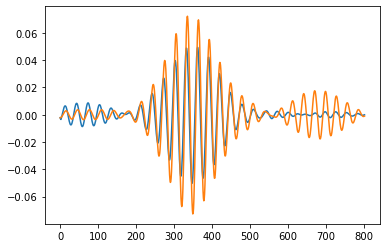

In [23]:
i = 10
print(periods[i])
plt.plot(np.gradient(np.gradient(tr.field[i])))
plt.plot(tr.laplacian[i]*4.2**2)

In [27]:
for tr in data:
    tr.pv = np.array([compute_phase_velocity(f, l, p, w=2)[0] for f, l, p in zip(tr.field, tr.laplacian, periods)])

Snippets/perform_reconstruction.py:175: RuntimeWarning: invalid value encountered in sqrt


In [31]:
# Moveaxis so that the time axis is now in slot 1 and the spatial axes are in slots 2&3 so that we can iterate over
# frequency and time to and operate on space
datafl = np.array([[laplacian(Atf, yy, xx, yw, xw) for Atf in Af] for Af in np.moveaxis(dataf, 3, 1)])

In [32]:
fielddatalap = np.array([laplacian(At, yy, xx, yw, xw) for At in np.moveaxis(fielddata, 2,0)])

In [33]:
# Rearrange both dataf & datafl so that we have ordering y, x, f, t for taking time domain wavespeeds
dataf = np.moveaxis(dataf, 0, 2)
datafl = np.moveaxis(datafl, [0, 1], [2, 3])

In [34]:
pv = get_phase_velocities(dataf[:,:,:,200:], datafl[:,:,:,200:], periods)

Snippets/perform_reconstruction.py:175: RuntimeWarning: invalid value encountered in sqrt


In [40]:
smax = np.argmax(np.abs(hilbert(tr.data)))

In [43]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

N = 256
vals1 = np.ones((N, 4))
vals1[:, 0] = np.linspace(255/255, 1, N)
vals1[:, 1] = np.linspace(108/255, 1, N)
vals1[:, 2] = np.linspace(12/255, 1, N)
newcmp1 = ListedColormap(vals1)

N = 256
vals2 = np.ones((N, 4))
vals2[:, 0] = np.linspace(1, 0, N)
vals2[:, 1] = np.linspace(1, 161/255, N)
vals2[:, 2] = np.linspace(1, 223/256, N)
newcmp2 = ListedColormap(vals2)

newcmp3 = ListedColormap(np.vstack([vals1,vals2]))

In [44]:
import sys
sys.path.append("ModelData")
import lysmer

In [45]:
_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,vpusc,vsusc,rhousc = np.loadtxt("ModelData/dfileusc.txt", unpack=True)  
_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,vpvtv,vsvtv,rhovtv = np.loadtxt("ModelData/dfilevtv.txt", unpack=True) 
hh = np.load("ModelData/z.npy")
hz = hh[:,0]
hv = hh[:,1]

In [46]:
hv = np.hstack([hv, hv[-4:],hv[-4:]])

In [47]:
uscvpk = np.array([lysmer.lysmer(len(hv), hv, vsusc/1000, vpusc/1000, rhousc/1000, 1/p)['vpk'] for p in periods])
vtvvpk = np.array([lysmer.lysmer(len(hv), hv, vsvtv/1000, vpvtv/1000, rhovtv/1000, 1/p)['vpk'] for p in periods])

/Users/jackbmuir/opt/miniconda3/envs/seismo/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/jackbmuir/opt/miniconda3/envs/seismo/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


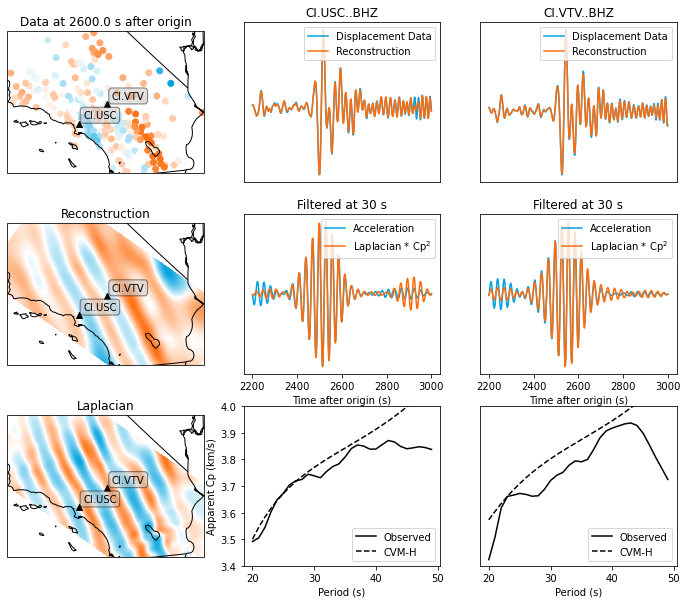

In [50]:
c = "#FF6C0C"
c2 = "#00A1DF"
colorgr = "#C8C8C8"

props = dict(boxstyle='round', facecolor=colorgr, alpha=0.5)

bounds = (np.min([tr.stats.longitude for tr in data]), 
          np.max([tr.stats.longitude for tr in data]), 
          np.min([tr.stats.latitude for tr in data]),
          np.max([tr.stats.latitude for tr in data]))

i = 400
j = 10# period index
fig, axes = plt.subplots(3,3, figsize=(12,10))

axes[0,0] = plt.subplot(3,3,1,projection=proj)
cax = axes[0,0].scatter(np.array([tr.stats.longitude for tr in data]), 
                        np.array([tr.stats.latitude for tr in data]),
                        c = np.array([tr.data[i] for tr in data]),
                        transform=ccrs.PlateCarree(), cmap=newcmp3)
axes[0,0].add_feature(coastline)
axes[0,0].add_feature(borders)
axes[0,0].add_feature(states_provinces)
axes[0,0].set_extent(bounds, geo)
axes[0,0].set_title(f"Data at {i*data[0].stats.delta + 2200} s after origin")


axes[1,0] = plt.subplot(3,3,4,projection=proj)
cax = axes[1,0] .contourf(evlon.reshape(64,128),
                          evlat.reshape(64,128), 
                          fielddata[:,:,i], 100, transform=ccrs.PlateCarree(), cmap=newcmp3)
axes[1,0].add_feature(coastline)
axes[1,0].add_feature(borders)
axes[1,0].add_feature(states_provinces)
axes[1,0].set_extent(bounds, geo)
axes[1,0].set_title("Reconstruction")


axes[2,0] = plt.subplot(3,3,7,projection=proj)
cax = axes[2,0] .contourf(evlon.reshape(64,128),
                          evlat.reshape(64,128), 
                          fielddatalap[i,:,:], 100, transform=ccrs.PlateCarree(), cmap=newcmp3)
axes[2,0].add_feature(coastline)
axes[2,0].add_feature(borders)
axes[2,0].add_feature(states_provinces)
axes[2,0].set_extent(bounds, geo)
axes[2,0].set_title("Laplacian")


tr1 = data.select(station="USC")[0]
axes[0,1].plot(tr1.times()+2200, tr1.data/ds, c2, label="Displacement Data")
axes[0,1].plot(np.hstack([tr1.times(), tr1.times()[-1]+tr1.stats.delta])+2200, tr1.reconstruction, c, label="Reconstruction")
axes[0,1].legend(loc="upper right")
axes[0,1].set_title(tr1.id)
axes[0,1].set_yticks([])
axes[0,1].set_xticks([])
axes[0,0].scatter(tr1.stats.longitude, tr1.stats.latitude, transform=ccrs.PlateCarree(), marker='^', color='k')
axes[1,0].scatter(tr1.stats.longitude, tr1.stats.latitude, transform=ccrs.PlateCarree(), marker='^', color='k')
axes[2,0].scatter(tr1.stats.longitude, tr1.stats.latitude, transform=ccrs.PlateCarree(), marker='^', color='k')
axes[0,0].text(tr1.stats.longitude+0.15, tr1.stats.latitude+0.15, f"{tr1.stats.network}.{tr1.stats.station}", bbox=props, transform=ccrs.PlateCarree())
axes[1,0].text(tr1.stats.longitude+0.15, tr1.stats.latitude+0.15, f"{tr1.stats.network}.{tr1.stats.station}", bbox=props, transform=ccrs.PlateCarree())
axes[2,0].text(tr1.stats.longitude+0.15, tr1.stats.latitude+0.15, f"{tr1.stats.network}.{tr1.stats.station}", bbox=props, transform=ccrs.PlateCarree())



axes[1,1].plot(np.hstack([tr1.times(), tr1.times()[-1]+tr1.stats.delta])+2200, np.gradient(np.gradient(tr1.field[j])), c2, label="Acceleration")
axes[1,1].plot(np.hstack([tr1.times(), tr1.times()[-1]+tr1.stats.delta])+2200, tr1.laplacian[j]*tr1.pv[j]**2, c, label=r"Laplacian * Cp$^2$")
axes[1,1].legend(loc="upper right")
axes[1,1].set_title(f"Filtered at {periods[j]} s")
axes[1,1].set_xlabel("Time after origin (s)")
axes[1,1].set_yticks([])


axes[2,1].plot(periods, tr1.pv, 'k', label="Observed")
axes[2,1].plot(periods, uscvpk, 'k--', label="CVM-H")
axes[2,1].legend(loc="lower right")
axes[2,1].set_ylabel("Apparent Cp (km/s)")
axes[2,1].set_ylim(3.4,4.0)
axes[2,1].set_xlabel("Period (s)")

tr2 = data.select(station="VTV")[0]
axes[0,2].plot(tr1.times()+2200, tr2.data/ds, c2, label="Displacement Data")
axes[0,2].plot(np.hstack([tr1.times(), tr1.times()[-1]+tr1.stats.delta])+2200, tr2.reconstruction, c, label="Reconstruction")
axes[0,2].legend(loc="upper right")
axes[0,2].set_title(tr2.id)
axes[0,2].set_xticks([])
axes[0,2].set_yticks([])
axes[0,0].scatter(tr2.stats.longitude, tr2.stats.latitude, transform=ccrs.PlateCarree(), marker='^', color='k')
axes[1,0].scatter(tr2.stats.longitude, tr2.stats.latitude, transform=ccrs.PlateCarree(), marker='^', color='k')
axes[2,0].scatter(tr2.stats.longitude, tr2.stats.latitude, transform=ccrs.PlateCarree(), marker='^', color='k')
axes[0,0].text(tr2.stats.longitude+0.15, tr2.stats.latitude+0.15, f"{tr2.stats.network}.{tr2.stats.station}", bbox=props, transform=ccrs.PlateCarree())
axes[1,0].text(tr2.stats.longitude+0.15, tr2.stats.latitude+0.15, f"{tr2.stats.network}.{tr2.stats.station}", bbox=props, transform=ccrs.PlateCarree())
axes[2,0].text(tr2.stats.longitude+0.15, tr2.stats.latitude+0.15, f"{tr2.stats.network}.{tr2.stats.station}", bbox=props, transform=ccrs.PlateCarree())



axes[1,2].plot(np.hstack([tr1.times(), tr1.times()[-1]+tr1.stats.delta])+2200, np.gradient(np.gradient(tr2.field[j])), c2, label="Acceleration")
axes[1,2].plot(np.hstack([tr1.times(), tr1.times()[-1]+tr1.stats.delta])+2200, tr2.laplacian[j]*tr2.pv[j]**2, c, label=r"Laplacian * Cp$^2$")
axes[1,2].legend(loc="upper right")
axes[1,2].set_title(f"Filtered at {periods[j]} s")
axes[1,2].set_xlabel("Time after origin (s)")
axes[1,2].set_yticks([])

axes[2,2].plot(periods, tr2.pv, 'k', label='Observed')
axes[2,2].plot(periods, vtvvpk, 'k--', label="CVM-H")
axes[2,2].legend(loc="lower right")
#axes[2,2].set_ylabel("Apparent Cp (km/s)")
axes[2,2].set_ylim(3.4,4.0)
axes[2,2].set_yticks([])
axes[2,2].set_xlabel("Period (s)")

fig.savefig("Tomo.pdf")

In [ ]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

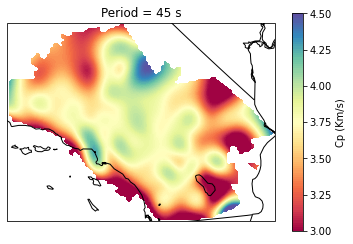

In [54]:
from scipy.interpolate import Rbf
from scipy.spatial import Delaunay

ip = 25
periods = np.array(range(20,50))
f = np.isfinite(np.array([tr.pv[ip] for tr in data]))
fig = plt.figure(figsize=(6,4))

ax = plt.subplot(111, projection=proj)

epsilon = 45000

xex = np.array([tr.stats.easting for tr in data])[f]
yex = np.array([tr.stats.northing for tr in data])[f]
itp = Rbf(xex, 
          yex, np.array([tr.pv[ip] for tr in data])[f], smooth=0.01, epsilon=epsilon)

exx, eyy = np.meshgrid(np.linspace(np.min(xex), np.max(xex), 100), np.linspace(np.min(yex), np.max(yex), 100))

out = itp(exx,eyy)

for i in range(exx.shape[0]):
    for j in range(exx.shape[1]):
        distances = np.sqrt((xex-exx[i,j])**2+(yex-eyy[i,j])**2)
        dist_sel = distances<2*epsilon
        if np.sum(dist_sel) <= 2:
            out[i,j] = np.nan #cannot possibly be within convex hull of local points then
        else:
            if not in_hull(np.array([[exx[i,j], eyy[i,j]]]), np.array([xex[dist_sel], yex[dist_sel]]).T):
                out[i,j] = np.nan
            

cax = ax.contourf(exx, eyy, np.clip(out, 3.0, 4.5), 100, cmap="Spectral")

ax.add_feature(coastline)
ax.add_feature(borders)
ax.add_feature(states_provinces)
ax.set_title(f"Period = {periods[ip]} s")
cbar = fig.colorbar(cax, ticks=[3, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5])
cbar.set_label("Cp (Km/s)")
fig.savefig("ca_cp_tomo.pdf")

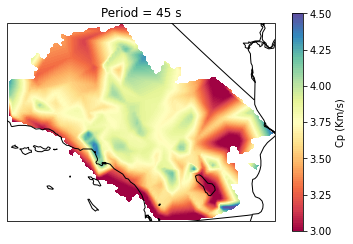

In [55]:
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay

ip = 25
periods = np.array(range(20,50))
f = np.isfinite(np.array([tr.pv[ip] for tr in data]))
fig = plt.figure(figsize=(6,4))

ax = plt.subplot(111, projection=proj)

epsilon = 45000

xex = np.array([tr.stats.easting for tr in data])[f]
yex = np.array([tr.stats.northing for tr in data])[f]
itp = LinearNDInterpolator(np.array([xex, 
          yex]).T, np.array([tr.pv[ip] for tr in data])[f])

exx, eyy = np.meshgrid(np.linspace(np.min(xex), np.max(xex), 100), np.linspace(np.min(yex), np.max(yex), 100))

out = itp(exx,eyy)

for i in range(exx.shape[0]):
    for j in range(exx.shape[1]):
        distances = np.sqrt((xex-exx[i,j])**2+(yex-eyy[i,j])**2)
        dist_sel = distances<2*epsilon
        if np.sum(dist_sel) <= 2:
            out[i,j] = np.nan #cannot possibly be within convex hull of local points then
        else:
            if not in_hull(np.array([[exx[i,j], eyy[i,j]]]), np.array([xex[dist_sel], yex[dist_sel]]).T):
                out[i,j] = np.nan
            

cax = ax.contourf(exx, eyy, np.clip(out, 3.0, 4.5), 100, cmap="Spectral")
ax.add_feature(coastline)
ax.add_feature(borders)
ax.add_feature(states_provinces)
ax.set_title(f"Period = {periods[ip]} s")
cbar = fig.colorbar(cax, ticks=[3, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5])
cbar.set_label("Cp (Km/s)")
fig.savefig("ca_cp_tomo_unsmooth.pdf")